In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

In [2]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Pyproj version
3.6.1


In [3]:
# Force garbage collection
import gc
gc.collect()

0

In [4]:
features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_Completed_LogDensity_2001_2020.parquet')

In [5]:
features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi_pre_interpolated                               float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

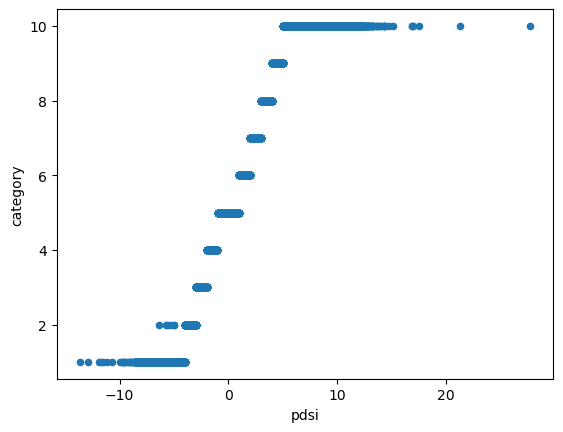

In [ ]:
# sample 1347276 rows for plotting
# features_plot = features.sample(1347276)
# fig, ax = plt.subplots()
# features_plot.plot.scatter(x='pdsi', y='pdsi_class', ax=ax)
# plt.show()

In [6]:
features.shape

(126317000, 23)

In [ ]:
# features.shape

(128056650, 22)

In [7]:
# check missing rate
features.isnull().sum() / features.shape[0]

lon                                          0.0
lat                                          0.0
day                                          0.0
dead_fuel_moisture_1000hr                    0.0
dead_fuel_moisture_100hr                     0.0
pdsi_pre_interpolated                        0.0
pdsi_class                                   0.0
max_air_temperature                          0.0
max_relative_humidity                        0.0
max_wind_speed                               0.0
min_air_temperature                          0.0
min_relative_humidity                        0.0
precipitation_amount                         0.0
specific_humidity                            0.0
surface_downwelling_shortwave_flux_in_air    0.0
wind_from_direction                          0.0
wind_speed                                   0.0
wind_direction_category                      0.0
SWE                                          0.0
Band1                                        0.0
LAI                 

## Merge weather feature w other features and label

In [39]:
veg_data = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')
slope_data = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_slope.parquet')
road_density_data = pd.read_parquet('../Clean_Data/road_density_match_weather_grid.parquet')

In [40]:
veg_data.shape, slope_data.shape, road_density_data.shape

((17703, 7), (62160, 5), (17703, 4))

In [41]:
# only keep lon, lat, and fire_attribute
veg_data = veg_data[['lon', 'lat','veg_type_details','fire_attribute','veg']]
# only keep lon, lat, slope_avg and slope_max
slope_data = slope_data[['lon', 'lat', 'slope_avg', 'slope_max']]

In [42]:
# confirm there is no duplicated rows
veg_data.duplicated().sum(), slope_data.duplicated().sum(), road_density_data.duplicated().sum()

(0, 0, 0)

In [25]:
veg_data.columns, slope_data.columns, road_density_data.columns

(Index(['lon', 'lat', 'veg_type_details', 'fire_attribute', 'veg'], dtype='object'),
 Index(['lon', 'lat', 'slope_avg', 'slope_max'], dtype='object'),
 Index(['lon', 'lat', 'road_density_km_km2', 'road_density_km_km2_log'], dtype='object'))

In [26]:
features.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'wind_direction_category', 'SWE',
       'Band1', 'LAI', 'pdsi', 'population_density_log'],
      dtype='object')

Downsample

In [27]:
fire_label = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Fire_Label/calfire_fod_fpa_2001_2020_fire_label_w_size_downsample.parquet')

In [28]:
# drop column Year
fire_label = fire_label.drop(columns=['Year'])

In [ ]:
mod_data = pd.merge(features, fire_label, on=['lon', 'lat', 'day'], how='inner')
# join veg_data
mod_data = pd.merge(mod_data, veg_data, on=['lon', 'lat'], how='inner')
# join slope_data
mod_data = pd.merge(mod_data, slope_data, on=['lon', 'lat'], how='inner')
# join road_density_data
mod_data = pd.merge(mod_data, road_density_data, on=['lon', 'lat'], how='inner')
# save to parquet
mod_data.to_parquet(f"../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_2001_2020.parquet")

In [42]:
# read the mod_data
mod_data = pd.read_parquet("../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_2001_2020.parquet")

In [43]:
# convert NWCG_CAUSE_CLASSIFICATION to string
mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
mod_Human = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]

In [44]:
mod_data.shape, mod_Human.shape

((15126439, 34), (15078176, 34))

In [45]:
mod_Human['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
None                                                  14975104
'Human'                                                 102232
'Human', 'Missing data/not specified/undetermined'         738
'Human', 'Natural'                                         102
Name: count, dtype: int64

In [46]:
mod_Human.to_parquet(f"../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_human_2001_2020.parquet")

In [30]:
# Force garbage collection
import gc
gc.collect()

1737

In [31]:
# read the mod_data
mod_data = pd.read_parquet("../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_human_2001_2020.parquet")

In [33]:
mod_data.shape

(15078176, 34)

In [34]:
original_veg = mod_data['veg'].unique()
# drop veg if veg contains Water, Urban, Agriculture
mod_data = mod_data[~mod_data['veg'].str.contains('Water|Urban|Agriculture')]
new_veg = mod_data['veg'].unique()

for veg in original_veg:
    if veg not in new_veg:
        print(veg)

Agriculture 
Urban 
Water 


In [35]:
mod_data.shape

(12227485, 34)

In [36]:
mod_data['IS_FIRE'].value_counts(normalize=True)

IS_FIRE
0    0.993948
1    0.006052
Name: proportion, dtype: float64

In [38]:
mod_data.to_parquet(f"../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_human_filter_veg_2001_2020.parquet")

Raw %

In [ ]:
def generate_fire_name(year):
    return f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/{year}_features_w_label.parquet"

for year in tqdm(range(2001, 2021), desc="Processing years"):
    fire_name = generate_fire_name(year)
    # print begin processing
    # print(f"Processing {fire_name}")
    fire_label = pd.read_parquet(fire_name)
    mod_data = pd.merge(features, fire_label, on=['lon', 'lat', 'day'], how='inner')
    # join veg_data
    mod_data = pd.merge(mod_data, veg_data, on=['lon', 'lat'], how='inner')
    # join slope_data
    mod_data = pd.merge(mod_data, slope_data, on=['lon', 'lat'], how='inner')
    # join road_density_data
    mod_data = pd.merge(mod_data, road_density_data, on=['lon', 'lat'], how='inner')
    # save to parquet
    mod_data.to_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Filter_Veg/{year}_features_w_label.parquet")

    mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
    mod_Human = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]
    mod_Human.to_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire/{year}_features_w_label.parquet")

    gc.collect()
    # print "data saved" and print its shape in one sentence
    # print("Data Saved")
    # print(f"Shape: {mod_data.shape}")
    # print sep line
    # print("="*80)

Processing years: 100%|██████████| 20/20 [23:29<00:00, 70.48s/it]


In [8]:
log_messages = []
# append current timestamp to log_messages
log_messages.append(f"Log messages for processing water years: {pd.Timestamp.now()}")

for year in tqdm(range(2002, 2021), desc="Processing Water Years"):
    prev_year = year - 1

    # Load data for both years
    prev_data_path = f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire/{prev_year}_features_w_label.parquet"
    curr_data_path = f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire/{year}_features_w_label.parquet"

    prev_data = pd.read_parquet(prev_data_path)
    curr_data = pd.read_parquet(curr_data_path)

    # Combine both years' data
    mod_data = pd.concat([prev_data, curr_data], ignore_index=True)

    # Filter for the water year range (Oct 1 - Sep 30)
    mod_data = mod_data[(mod_data['day'] >= f"{prev_year}-10-01") & (mod_data['day'] <= f"{year}-09-30")]

    # Save with water year notation
    mod_data.to_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire_Water_Year/{year}_features_w_label.parquet")

    # create a log message showing the min and max day of saved data
    log_message = f"Data for Water Year {year} saved, min day: {mod_data['day'].min()}, max day: {mod_data['day'].max()}"
    log_messages.append(log_message)

    gc.collect()

Processing Water Years: 100%|██████████| 19/19 [06:31<00:00, 20.61s/it]


In [9]:
# Save the log messages to a log file
with open('../Logs/water_year_evaluation_data_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))

print("Log file saved to '../Logs/water_year_evaluation_data_log.txt'")

Log file saved to '../Logs/water_year_evaluation_data_log.txt'


In [47]:
log_messages = []
# append current timestamp to log_messages
log_messages.append(f"Log messages for filtering veg types: {pd.Timestamp.now()}")

for year in tqdm(range(2002, 2021), desc="Processing Water Years"):

    # log the year being processed
    log_message = f"Processing year: {year}"
    log_messages.append(log_message)

    # Load data for current years
    curr_data_path = f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire_Water_Year/{year}_features_w_label.parquet"
    mod_data = pd.read_parquet(curr_data_path)

    # log the shape of the data before filtering
    log_message = f"Data shape before filtering veg types for year {year}: {mod_data.shape}"
    log_messages.append(log_message)

    original_veg = mod_data['veg'].unique()
    # drop veg if veg contains Water, Urban, Agriculture
    mod_data = mod_data[~mod_data['veg'].str.contains('Water|Urban|Agriculture')]
    new_veg = mod_data['veg'].unique()

    # log the veg types that are dropped
    for veg in original_veg:
        if veg not in new_veg:
            log_message = f"Dropped veg type: {veg} from year {year}"
            log_messages.append(log_message)

    # log the shape of the data after filtering
    log_message = f"Data shape after filtering veg types for year {year}: {mod_data.shape}"
    log_messages.append(log_message)

    # Save the filtered data
    mod_data.to_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire_Water_Year_Filter_Veg/{year}_features_w_label.parquet")

    # free up memory
    del mod_data

    gc.collect()

Processing Water Years: 100%|██████████| 19/19 [06:30<00:00, 20.56s/it]


In [48]:
# Save the log messages to a log file
with open('../Logs/filter_veg_evaluation_data_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))

print("Log file saved to '../Logs/filter_veg_evaluation_data_log.txt'")

Log file saved to '../Logs/filter_veg_evaluation_data_log.txt'


In [ ]:
# for year in tqdm(range(2001, 2021), desc="Processing years"):
#     mod_data = pd.read_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/{year}_features_w_label.parquet")

#     mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
#     mod_Human = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]

#     # save to parquet
#     mod_Human.to_parquet(f"../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire/{year}_features_w_label.parquet")

#     gc.collect()

Processing years: 100%|██████████| 20/20 [04:41<00:00, 14.07s/it]


In [49]:
mod_Human.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'wind_direction_category', 'SWE',
       'Band1', 'LAI', 'pdsi', 'population_density_log', 'IS_FIRE',
       'NWCG_CAUSE_CLASSIFICATION', 'min_FIRE_SIZE', 'max_FIRE_SIZE', 'Year',
       'veg_type_details', 'fire_attribute', 'veg', 'slope_avg', 'slope_max',
       'road_density_km_km2', 'road_density_km_km2_log'],
      dtype='object')

In [50]:
mod_Human.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi_pre_interpolated                               float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              